In [ ]:
#Options and todos:

#Options for preprocessing:
#Data is weighted to the amount of target_channels it ends up on the same day as (so more than one target_channel means)
#Can throw in nodupe by day and channel so that more volume per day doesn't affect anything

#todos:
#**add in 5,15,30 payments from the first OR last contact 
#^^(maybe do different nn's for those to see which is most important, 
#^^first needs parameters like no longer than 5 days before the payment depending on the contact)
#^^last needs the same parameters





In [383]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from itertools import chain, combinations
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Load the data
jan_dlq2 = pd.read_csv(r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\DL\channel_engage\data\jan_dlq2.csv")
events_df = pd.read_csv(r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\DL\channel_engage\data\events_df.csv")
 
jan_dlq2['src_data_dt'] = pd.to_datetime(jan_dlq2['src_data_dt'], format="%d%b%y:%H:%M:%S").dt.date
events_df['date'] = pd.to_datetime(events_df["date"], format='%d-%b-%y').dt.date

#get month from cycle_dt and date so we can merge on month
jan_dlq2['month'] = pd.to_datetime(jan_dlq2["cycle_dt"], format='%m/%d/%Y').dt.to_period('M').dt.to_timestamp()
events_df['month'] = pd.to_datetime(events_df["date"], format='%Y-%m-%d').dt.to_period('M').dt.to_timestamp()

print(jan_dlq2.head(), events_df.head(), sep='\n\n')
print(jan_dlq2.shape, events_df.shape)

   acct_ref_nb  acct_balance  tot_delq_amt  min_delq_amt  probability_score  \
0       125001           250           100            25              0.534   
1       125001           250           100            25              0.534   
2       125001           250           100            25              0.534   
3       125001           250           100            25              0.534   
4       125001           250           100            25              0.534   

  src_data_dt  cycle_dt state  zip_code   dlq_30   dlq_60   dlq_90  \
0  2022-01-31  1/5/2022    KY     40288  current  current  current   
1  2022-01-31  1/5/2022    KY     40288  current  current  current   
2  2022-01-31  1/5/2022    KY     40288  current  current  current   
3  2022-01-31  1/5/2022    KY     40288  current  current  current   
4  2022-01-31  1/5/2022    KY     40288  current  current  current   

  exclusion_type       roll_30       roll_60       roll_90      month  
0       elgiible  roll forward  

In [384]:
# One-hot encode the 'channel' column
events_df_encoded = pd.get_dummies(events_df, columns=['channel'], prefix='', prefix_sep='')

# Aggregate by 'acct_ref_nb' and 'date' and sum the occurrences
events_df_agg = events_df_encoded.groupby(['acct_ref_nb', 'date', 'month']).sum().reset_index()

# Create binary 'PYMT' column
events_df_agg['PYMT'] = events_df_agg['PYMT'].apply(lambda x: 1 if x > 0 else 0)
print(events_df_agg.head(), events_df_agg.shape)

   acct_ref_nb        date      month  E-LETTER  EMAIL  E_LETTER  INBOUND  \
0       125001  2022-01-31 2022-01-01         0      1         1        1   
1       125001  2022-02-01 2022-02-01         1      1         0        1   

   LETTER  LOGIN  OUTBOUND  PROMISE  PYMT  PYMT_PROG  TEXT  
0       2      2         1        1     1          2     3  
1       2      2         1        1     1          1     2   (2, 14)


In [385]:


jan_dlq_no_dupes = jan_dlq2.drop_duplicates()

#events_df2 = events_df.drop_duplicates()


print(jan_dlq_no_dupes)
print(jan_dlq_no_dupes.shape)
#print(events_df2.shape)

    acct_ref_nb  acct_balance  tot_delq_amt  min_delq_amt  probability_score  \
0        125001           250           100            25              0.534   
15       125001           500           250            50              0.734   

   src_data_dt  cycle_dt state  zip_code   dlq_30   dlq_60   dlq_90  \
0   2022-01-31  1/5/2022    KY     40288  current  current  current   
15  2022-02-01  2/6/2022    KY     40288  current  current  current   

   exclusion_type        roll_30        roll_60        roll_90      month  
0        elgiible   roll forward   roll forward   roll forward 2022-01-01  
15       elgiible  roll backward  roll backward  roll backward 2022-02-01  
(2, 17)


In [386]:

# Merge data on acct_ref_nb and month
data = pd.merge(events_df, jan_dlq_no_dupes, on=["acct_ref_nb", "month"], how="left") #events_df_agg and jan_dlq_no_dupes for when this is implemented, check the data names for the ROC at the end
print(data.head())
print(data.shape)

   acct_ref_nb        date   channel      month  acct_balance  tot_delq_amt  \
0       125001  2022-01-31     EMAIL 2022-01-01           250           100   
1       125001  2022-01-31      TEXT 2022-01-01           250           100   
2       125001  2022-01-31    LETTER 2022-01-01           250           100   
3       125001  2022-01-31  E_LETTER 2022-01-01           250           100   
4       125001  2022-01-31  OUTBOUND 2022-01-01           250           100   

   min_delq_amt  probability_score src_data_dt  cycle_dt state  zip_code  \
0            25              0.534  2022-01-31  1/5/2022    KY     40288   
1            25              0.534  2022-01-31  1/5/2022    KY     40288   
2            25              0.534  2022-01-31  1/5/2022    KY     40288   
3            25              0.534  2022-01-31  1/5/2022    KY     40288   
4            25              0.534  2022-01-31  1/5/2022    KY     40288   

    dlq_30   dlq_60   dlq_90 exclusion_type       roll_30       roll

In [387]:
# Split the data based on interaction_channels and target_channels
interaction_channels = ['EMAIL', 'TEXT', 'LETTER', 'E-LETTER', 'OUTBOUND'] 
interaction_df = data[data['channel'].isin(interaction_channels)]

# Rename column name channel to interaction_channel
interaction_df= interaction_df.rename(columns={'channel': 'interaction_channel'})

print(interaction_df.shape)
print(interaction_df.head())

(14, 19)
    acct_ref_nb        date interaction_channel      month  acct_balance  \
0        125001  2022-01-31               EMAIL 2022-01-01           250   
1        125001  2022-01-31                TEXT 2022-01-01           250   
2        125001  2022-01-31              LETTER 2022-01-01           250   
4        125001  2022-01-31            OUTBOUND 2022-01-01           250   
10       125001  2022-01-31              LETTER 2022-01-01           250   

    tot_delq_amt  min_delq_amt  probability_score src_data_dt  cycle_dt state  \
0            100            25              0.534  2022-01-31  1/5/2022    KY   
1            100            25              0.534  2022-01-31  1/5/2022    KY   
2            100            25              0.534  2022-01-31  1/5/2022    KY   
4            100            25              0.534  2022-01-31  1/5/2022    KY   
10           100            25              0.534  2022-01-31  1/5/2022    KY   

    zip_code   dlq_30   dlq_60   dlq_90 exclusi

In [388]:

target_channels = ['INBOUND', 'PYMT', 'LOGIN', 'PROMISE', 'PYMT_PROG']
target_df = data[data['channel'].isin(target_channels)]

# Rename channel values in target_df
target_df= target_df.rename(columns={'channel': 'target_channel'})

print(target_df.shape)
print(target_df)


(14, 19)
    acct_ref_nb        date target_channel      month  acct_balance  \
5        125001  2022-01-31        INBOUND 2022-01-01           250   
6        125001  2022-01-31           PYMT 2022-01-01           250   
7        125001  2022-01-31        PROMISE 2022-01-01           250   
8        125001  2022-01-31      PYMT_PROG 2022-01-01           250   
9        125001  2022-01-31          LOGIN 2022-01-01           250   
11       125001  2022-01-31          LOGIN 2022-01-01           250   
13       125001  2022-01-31      PYMT_PROG 2022-01-01           250   
15       125001  2022-02-01           PYMT 2022-02-01           500   
21       125001  2022-02-01        INBOUND 2022-02-01           500   
22       125001  2022-02-01           PYMT 2022-02-01           500   
23       125001  2022-02-01        PROMISE 2022-02-01           500   
24       125001  2022-02-01      PYMT_PROG 2022-02-01           500   
25       125001  2022-02-01          LOGIN 2022-02-01           500 

In [389]:
#split up the interaction and target channels into their own columns

interaction_channels = ['email', 'text', 'letter', 'e-letter', 'outbound'] 
# Function to get interaction channel
def get_interaction_channel(channel):
    if channel in interaction_channels:
        return channel
    return "No channel"

target_channels = ['inbound', 'pymt', 'login', 'promise', 'pymt_prog']
# Function to get target channel
def get_target_channel(channel):
    if channel in target_channels:
        return channel
    return "No pymt"

# Apply these functions to the data
data['interaction_channel'] = data['channel'].apply(get_interaction_channel)
data['target_channel'] = data['channel'].apply(get_target_channel)

# Drop the original channel column as it's no longer needed
data = data.drop(columns=['channel'])

#print(data.head())
#print(data.shape)   

In [390]:
result_df = pd.merge(interaction_df[['acct_ref_nb', 'src_data_dt', 'interaction_channel']], target_df, on=['acct_ref_nb', 'src_data_dt'], how='inner')
print(result_df.head())
print(result_df.shape)


   acct_ref_nb src_data_dt interaction_channel        date target_channel  \
0       125001  2022-01-31               EMAIL  2022-01-31        INBOUND   
1       125001  2022-01-31               EMAIL  2022-01-31           PYMT   
2       125001  2022-01-31               EMAIL  2022-01-31        PROMISE   
3       125001  2022-01-31               EMAIL  2022-01-31      PYMT_PROG   
4       125001  2022-01-31               EMAIL  2022-01-31          LOGIN   

       month  acct_balance  tot_delq_amt  min_delq_amt  probability_score  \
0 2022-01-01           250           100            25              0.534   
1 2022-01-01           250           100            25              0.534   
2 2022-01-01           250           100            25              0.534   
3 2022-01-01           250           100            25              0.534   
4 2022-01-01           250           100            25              0.534   

   cycle_dt state  zip_code   dlq_30   dlq_60   dlq_90 exclusion_type  \
0

In [391]:
# Merge them back together: this way gives payment credit to each interaction that happened the same day as the payment 
# and is exponentially more when you have more than one target on one day
merged_target_interact_df = pd.merge(interaction_df[['acct_ref_nb', 'src_data_dt', 'interaction_channel']], target_df,on=["acct_ref_nb", "src_data_dt"], how="left")
print(merged_target_interact_df.head())
print(merged_target_interact_df.shape)

   acct_ref_nb src_data_dt interaction_channel        date target_channel  \
0       125001  2022-01-31               EMAIL  2022-01-31        INBOUND   
1       125001  2022-01-31               EMAIL  2022-01-31           PYMT   
2       125001  2022-01-31               EMAIL  2022-01-31        PROMISE   
3       125001  2022-01-31               EMAIL  2022-01-31      PYMT_PROG   
4       125001  2022-01-31               EMAIL  2022-01-31          LOGIN   

       month  acct_balance  tot_delq_amt  min_delq_amt  probability_score  \
0 2022-01-01           250           100            25              0.534   
1 2022-01-01           250           100            25              0.534   
2 2022-01-01           250           100            25              0.534   
3 2022-01-01           250           100            25              0.534   
4 2022-01-01           250           100            25              0.534   

   cycle_dt state  zip_code   dlq_30   dlq_60   dlq_90 exclusion_type  \
0

In [392]:
#Preprocessing
#check the missing values before dropna
#print(merged_target_interact_df.isnull().sum())

#dropna from the merged_target_interact_df
#merged_target_interact_df = merged_target_interact_df.dropna()
merged_target_interact_df = merged_target_interact_df.dropna(subset=['target_channel'])
merged_target_interact_df = merged_target_interact_df.dropna(subset=['interaction_channel'])
merged_target_interact_df = merged_target_interact_df.dropna(subset=['acct_ref_nb'])

#check the missing values after dropna
#print(merged_target_interact_df.isnull().sum())

# Ensure the 'src_data_dt' column is of datetime type and then add year, month and day columns
merged_target_interact_df['src_data_dt'] = pd.to_datetime(merged_target_interact_df['src_data_dt'])
merged_target_interact_df['src_data_year'] = merged_target_interact_df['src_data_dt'].dt.year
merged_target_interact_df['src_data_month'] = merged_target_interact_df['src_data_dt'].dt.month
merged_target_interact_df['src_data_day'] = merged_target_interact_df['src_data_dt'].dt.day

# Drop any non-essential columns
data = merged_target_interact_df.drop(columns=['cycle_dt', 'src_data_dt', 'date', 'month','acct_ref_nb']) #account number is not needed because identifier is src_data_dt

#print(data.head())
print(data.shape)

# Crosstab between interaction channels and target channels
contingency_table = pd.crosstab(merged_target_interact_df['interaction_channel'], merged_target_interact_df['target_channel'])

print("numbers will be inflated due to weighting per target_channel, interaction weight per target channel =", contingency_table)


(98, 18)
target_channel       INBOUND  LOGIN  PROMISE  PYMT  PYMT_PROG
interaction_channel                                          
E-LETTER                   1      2        1     2          1
EMAIL                      2      4        2     3          3
LETTER                     4      8        4     6          6
OUTBOUND                   2      4        2     3          3
TEXT                       5     10        5     7          8


In [393]:



# Define feature lists
numerical_features = ['acct_balance', 'tot_delq_amt', 'min_delq_amt', 'probability_score', 'src_data_year', 
                      'src_data_month', 'src_data_day']
categorical_features = [col for col in data.columns if col not in numerical_features + [ 'target_channel']] #'interaction_channel' is needed in here while target_channel is the y variable

# Define transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define X and y
X = data.drop(columns=['target_channel'])
# Use LabelEncoder to encode target_channel
label_encoder = LabelEncoder()
y = data['target_channel']
y_encoded = label_encoder.fit_transform(y)

# Preprocess the data
X = preprocessor.fit_transform(X)

# If X is a sparse matrix, convert to a dense matrix
if hasattr(X, "todense"):
    X = X.todense()

# Split the data
X_train, X_temp, y_train_encoded, y_temp_encoded = train_test_split(X, y_encoded, test_size=0.4)
X_val, X_test, y_val_encoded, y_test_encoded = train_test_split(X_temp, y_temp_encoded, test_size=0.5)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val_encoded)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test_encoded)

# Convert to PyTorch datasets and create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [394]:
#check your data before modeling, remember this data is not scaled meaning the volume is off 
print(X_train_tensor.shape, y_train_tensor.shape, X_val_tensor.shape, y_val_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)
print(data['target_channel'].value_counts())


torch.Size([58, 24]) torch.Size([58]) torch.Size([20, 24]) torch.Size([20]) torch.Size([20, 24]) torch.Size([20])
LOGIN        28
PYMT         21
PYMT_PROG    21
INBOUND      14
PROMISE      14
Name: target_channel, dtype: int64


In [395]:
# Assuming you have the number of unique classes in a variable num_classes
num_classes = len(y.unique())  # Number of unique classes in the target variable

# Define the neural network
class MultiClassNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiClassNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, output_size)  # Number of output units equals number of classes
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation function for hidden layers
        x = self.dropout1(x)         # Dropout layer to prevent overfitting
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # Removed sigmoid here; softmax is implicitly applied by the cross-entropy loss later
        return x

MultiClassNet = MultiClassNet(X_train.shape[1], num_classes)

# Change the loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()  # Note: This expects raw scores (logits) and applies softmax internally

optimizer = optim.Adam(MultiClassNet.parameters(), lr=0.001, weight_decay=1e-5)  # Weight decay is L2 regularization


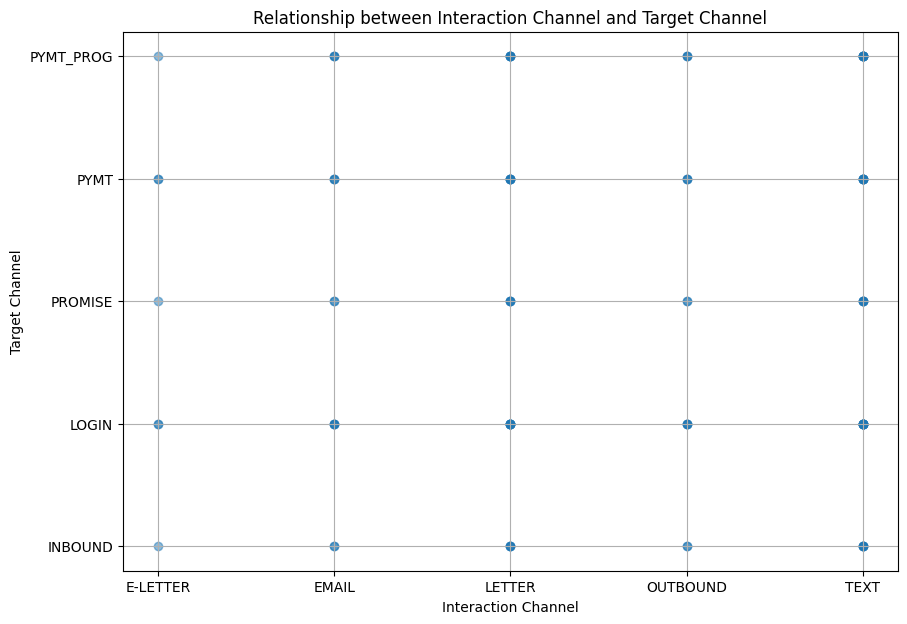

In [396]:
import matplotlib.pyplot as plt

# Using LabelEncoder for interaction_channel
interaction_encoder = LabelEncoder()
interaction_encoded = interaction_encoder.fit_transform(merged_target_interact_df['interaction_channel'])

# We've already encoded the target_channel with label_encoder
plt.figure(figsize=(10, 7))
plt.scatter(interaction_encoded, y_encoded, alpha=0.5)
plt.xlabel('Interaction Channel')
plt.ylabel('Target Channel')
plt.title('Relationship between Interaction Channel and Target Channel')
plt.xticks(ticks=range(len(interaction_encoder.classes_)), labels=interaction_encoder.classes_)
plt.yticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_)
plt.grid(True)
plt.show()


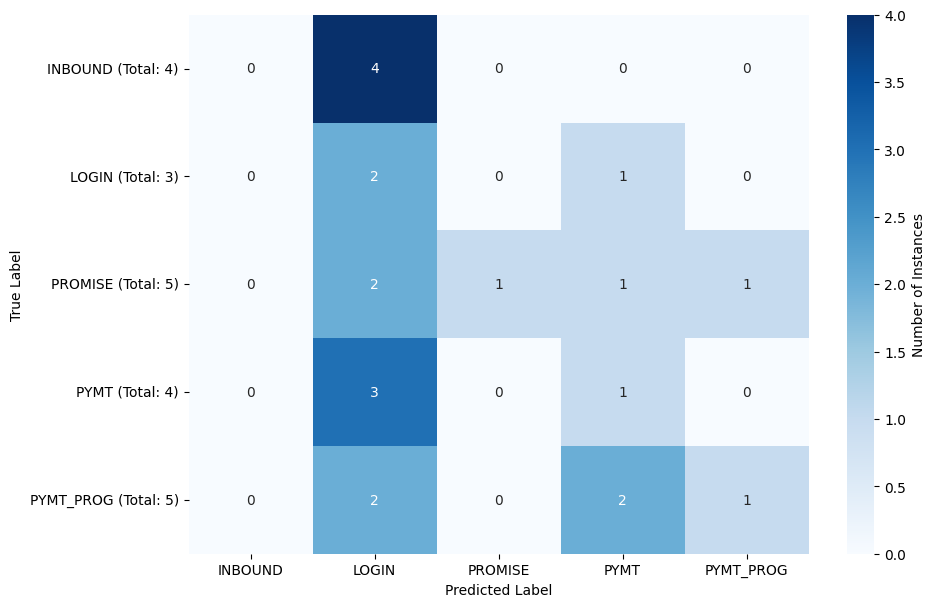

In [397]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true is the ground truth and y_pred are the predicted labels
y_true = y_test_encoded
y_pred = MultiClassNet(X_test_tensor).argmax(dim=1).numpy()  # assuming `model` is your PyTorch model

#--------------------------------------------------------------------------------------------------
# Calculate totals for each class
totals = matrix.sum(axis=1)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=[f"{cls} (Total: {total})" for cls, total in zip(label_encoder.classes_, totals)], ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
cbar = ax.collections[0].colorbar
cbar.set_label("Number of Instances")
plt.show()
#    The x-axis (Predicted Label) shows the classes predicted by the model.
#    The y-axis (True Label) represents the actual classes in the data.
#    Each cell in the matrix then shows the count of how many times a class (from y_true) was predicted as another class (from y_pred).

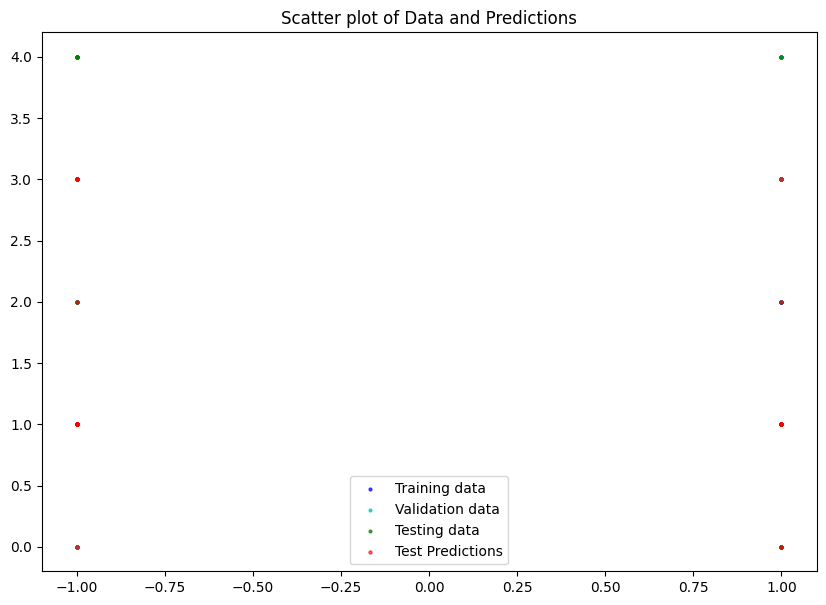

In [398]:
#Plots your training validation and test data

def plot_all_sets(train_data, train_labels, 
                  val_data, val_labels, 
                  test_data, test_labels, 
                  test_predictions=None):
    """
    Plots training data, validation data, test data, and predictions.
    """
    plt.figure(figsize=(10, 7))
    
    # Convert tensors to numpy if required
    if isinstance(train_data, torch.Tensor):
        train_data = train_data.numpy()
        train_labels = train_labels.numpy()
    if isinstance(val_data, torch.Tensor):
        val_data = val_data.numpy()
        val_labels = val_labels.numpy()
    if isinstance(test_data, torch.Tensor):
        test_data = test_data.numpy()
        test_labels = test_labels.numpy()
    if isinstance(test_predictions, torch.Tensor):
        test_predictions = test_predictions.numpy()

    # Just plot the first dimension (for simplicity) vs. labels. You can change dimensions if you want
    plt.scatter(train_data[:, 0], train_labels, c="b", s=4, alpha=0.7, label="Training data")
    plt.scatter(val_data[:, 0], val_labels, c="c", s=4, alpha=0.7, label="Validation data")
    plt.scatter(test_data[:, 0], test_labels, c="g", s=4, alpha=0.7, label="Testing data")

    if test_predictions is not None:
        plt.scatter(test_data[:, 0], test_predictions, c="r", s=5, label="Test Predictions", alpha=0.6)

    plt.legend(prop={"size": 10})
    plt.title("Scatter plot of Data and Predictions")
    plt.show()

# Predictions for test set taking out logits by using argmax
y_pred = MultiClassNet(X_test_tensor).argmax(dim=1).numpy()

# Plot
plot_all_sets(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, y_pred)


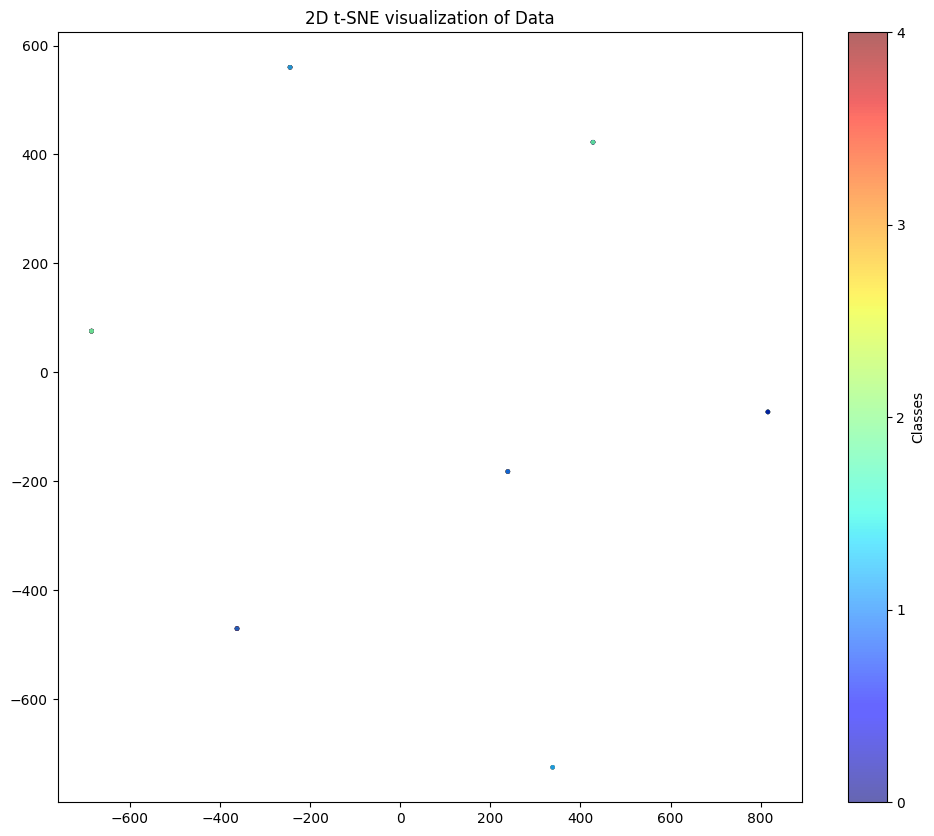

In [399]:
from sklearn.manifold import TSNE
import numpy as np

# Combine data and labels
X_combined = np.vstack([X_train, X_val, X_test])
y_combined = np.hstack([y_train_encoded, y_val_encoded, y_test_encoded])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

# Plotting
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_combined, cmap='jet', alpha=0.6, s=5)

# Create a legend
colorbar = plt.colorbar(scatter, ticks=range(num_classes))
colorbar.set_label('Classes')
plt.title("2D t-SNE visualization of Data")
plt.show()


Epoch 1/30 - Training Loss: 1.6268, Validation Loss: 1.6116, Validation Accuracy: 15.00%
Epoch 2/30 - Training Loss: 1.5717, Validation Loss: 1.6104, Validation Accuracy: 15.00%
Epoch 3/30 - Training Loss: 1.6164, Validation Loss: 1.6099, Validation Accuracy: 15.00%
Epoch 4/30 - Training Loss: 1.5899, Validation Loss: 1.6105, Validation Accuracy: 15.00%
Epoch 5/30 - Training Loss: 1.6003, Validation Loss: 1.6109, Validation Accuracy: 15.00%
Epoch 6/30 - Training Loss: 1.5833, Validation Loss: 1.6116, Validation Accuracy: 15.00%
Epoch 7/30 - Training Loss: 1.6012, Validation Loss: 1.6125, Validation Accuracy: 15.00%
Epoch 8/30 - Training Loss: 1.5729, Validation Loss: 1.6130, Validation Accuracy: 15.00%
Epoch 9/30 - Training Loss: 1.5850, Validation Loss: 1.6137, Validation Accuracy: 15.00%
Epoch 10/30 - Training Loss: 1.5893, Validation Loss: 1.6144, Validation Accuracy: 15.00%
Epoch 11/30 - Training Loss: 1.5993, Validation Loss: 1.6151, Validation Accuracy: 15.00%
Epoch 12/30 - Train

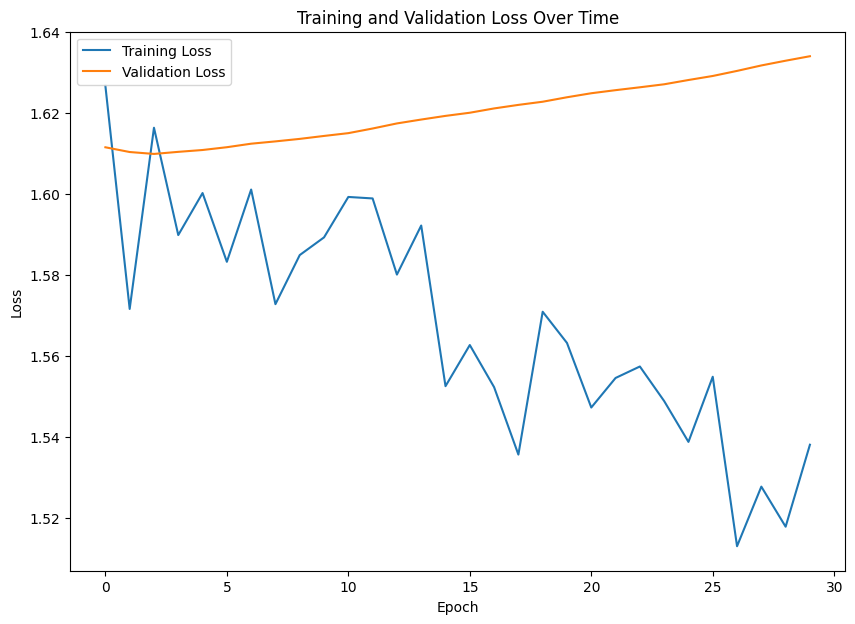

Test Accuracy: 25.00%


In [400]:
# %%
epochs = 30
def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs):
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        
        # Training loop
        total_loss = 0
        for batch in train_loader:
            # Split batch into data and target
            data, target = batch
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            
            # Calculate loss
            loss = loss_fn(outputs, target)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Accumulate loss for the epoch
            total_loss += loss.item()
        
        average_train_loss = total_loss / len(train_loader)
        train_loss_history.append(average_train_loss)
        
        # Validation loop
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        correct = 0
        with torch.no_grad():  # No need to track gradients during validation
            for batch in val_loader:
                data, target = batch
                outputs = model(data)
                
                # Calculate loss
                loss = loss_fn(outputs, target)
                
                # Accumulate loss for the epoch
                total_val_loss += loss.item()
                
                # Count correct predictions
                pred = outputs.argmax(dim=1)
                correct += (pred == target).sum().item()
                
        average_val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(average_val_loss)
        
        # Print loss and accuracy for the epoch
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {100 * correct/len(val_dataset):.2f}%")
    
    return train_loss_history, val_loss_history

# Train the model
train_loss, val_loss = train_model(MultiClassNet, loss_fn, optimizer, train_loader, val_loader, epochs=30)

# %%

# Plot the training and validation loss
plt.figure(figsize=(10,7))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

# %%

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    print(f'Test Accuracy: {100 * correct/total:.2f}%')

evaluate_model(MultiClassNet, test_loader)


              precision    recall  f1-score   support

     INBOUND       0.00      0.00      0.00         2
       LOGIN       0.42      0.56      0.48         9
     PROMISE       0.00      0.00      0.00         4
        PYMT       0.00      0.00      0.00         1
   PYMT_PROG       0.00      0.00      0.00         4

    accuracy                           0.25        20
   macro avg       0.08      0.11      0.10        20
weighted avg       0.19      0.25      0.21        20



c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

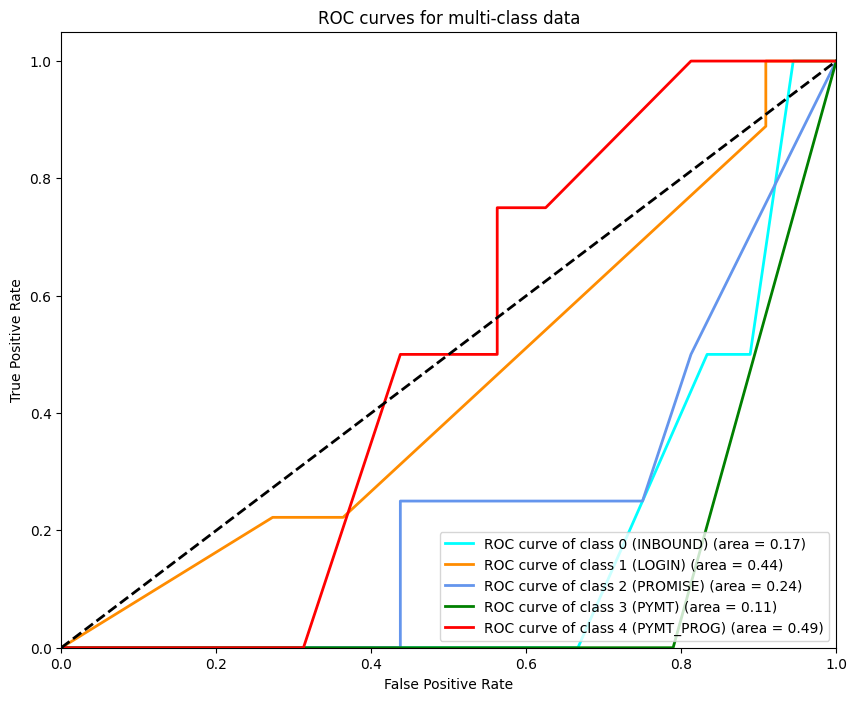

Log Loss: 6.7087


In [401]:
#metrics you can consider:

#    Classification Report: This provides a breakdown of precision, recall, and f1-score for each class.
#    Macro and Micro Averaging: Especially useful if there's a class imbalance.
#    ROC Curve for Multi-class: Compute the ROC curve for each class against the rest, then visualize all the ROC curves together.
#    Area Under Curve (AUC) for Multi-class: Like the ROC, but provides a single score for each class's performance.
#    Log-Loss: Gives a measure of model's performance; smaller values are better.

from sklearn.metrics import classification_report, roc_curve, auc, log_loss
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Predictions: could also use y_pred = MultiClassNet(X_test_tensor).argmax(dim=1).numpy()
y_pred_test_probs = MultiClassNet(X_test_tensor)
y_pred_test = torch.argmax(y_pred_test_probs, dim=1).numpy()

# Classification Report: This provides a breakdown of precision, recall, and f1-score for each class.
print(classification_report(y_test_encoded, y_pred_test, target_names=label_encoder.classes_))

# ROC and AUC for multi-class
#An AUC of 1.0 means the model has perfect discrimination, while an AUC of 0.5 means the model is no better than random guessing. Under 0.5 means the class labels might be inverted, or the classifier is consistently wrong. This is usually an anomaly.
#ROC curve by class, the closer to the top-left corner, the better the model is at predicting that class.
y_test_bin = label_binarize(y_test_encoded, classes=range(num_classes))
y_pred_bin = y_pred_test_probs.detach().numpy()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves: ROC Curve for Multi-class: Compute the ROC curve for each class against the rest, then visualize all the ROC curves together.
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} ({1}) (area = {2:0.2f})'
             ''.format(i, label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multi-class data')
plt.legend(loc="lower right")
plt.show()

# Log-Loss: Gives a measure of model's performance; smaller values are better.
loss = log_loss(y_test_encoded, y_pred_bin)
print(f"Log Loss: {loss:.4f}")
